<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

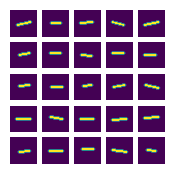

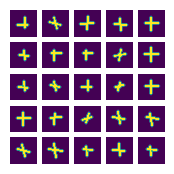

In [3]:
from scipy.ndimage import rotate
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [4]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation (7 )
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28) -> sequence of 7 images of size 28x28
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            # for k in range(highest_integer + 1):  # Third addend
                # i_char = to_padded_chars(i, max_len=max_int_length) # convert integers to strings of constant length [20->' 20']
                # j_char = to_padded_chars(j, max_len=max_int_length, pad_right=True)
                # k_char = to_padded_chars(k, max_len=max_int_length, pad_right=True)

            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 7: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #1111

X_text: "5-55 " = y_text: "-50"


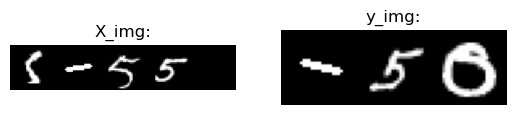

Query #8678

X_text: "43+39" = y_text: "82 "


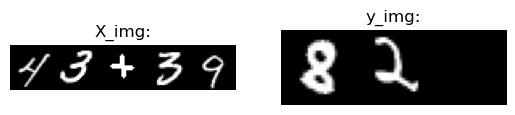

Query #3361

X_text: "16-80" = y_text: "-64"


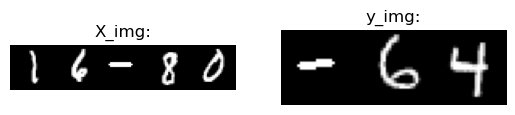

Query #8508

X_text: "42+54" = y_text: "96 "


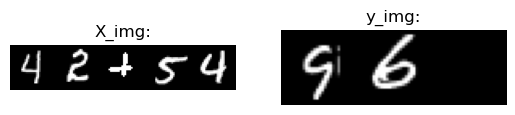

Query #6147

X_text: "30-73" = y_text: "-43"


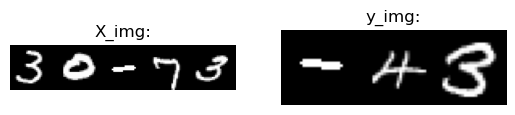

Query #3828

X_text: "19+14" = y_text: "33 "


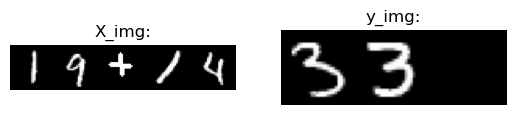

Query #729

X_text: "3-64 " = y_text: "-61"


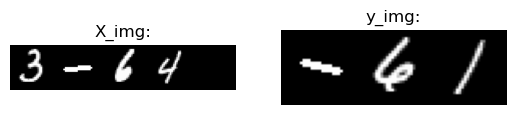

Query #1707

X_text: "8-53 " = y_text: "-45"


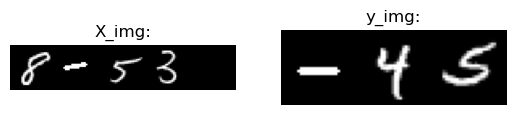

Query #9907

X_text: "49-53" = y_text: "-4 "


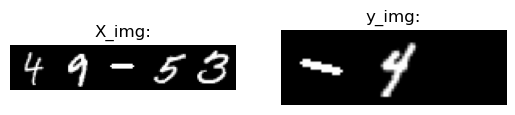

Query #9513

X_text: "47-56" = y_text: "-9 "


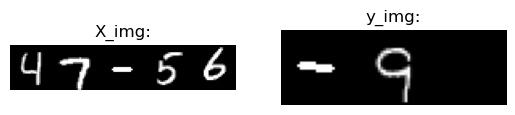

In [5]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [6]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [7]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [8]:
## Your code (look at the assignment description for your tasks for text-to-text model):









---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [21]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization

In [22]:
# def build_text_to_image_model(max_query_length, unique_characters):
#     # Text input
#     text_input = Input(shape=(max_query_length, len(unique_characters)))
    
#     # Encoder (LSTM)
#     encoded_text = LSTM(256)(text_input)

#     # Reshape to prepare for deconvolutional layers
#     reshaped_text = RepeatVector(7 * 7)(encoded_text)
#     reshaped_text = tf.keras.layers.Reshape((7, 7, 256))(reshaped_text)

#     # Decoder for image generation (Conv2DTranspose)
#     image_decoder = Sequential([
#         Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=(2, 2)),
#         BatchNormalization(),
#         Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2)),
#         BatchNormalization(),
#         Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2)),
#         BatchNormalization(),
#         Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2)),
#         BatchNormalization(),
#         Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', strides=(2, 2))
#     ])

#     # Apply the decoder to the reshaped text
#     generated_image = image_decoder(reshaped_text)
    
#     # Modify the last layer to match the number of pixels in your images
#     output_layer = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', strides=(2, 2))(generated_image)

#     # Build the text-to-image model
#     text_to_image_model = Model(inputs=text_input, outputs=output_layer)
#     text_to_image_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

#     return text_to_image_model


In [42]:
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, TimeDistributed

def build_text2image_model(show_summary: bool = False):
    # We start by initializing a sequential model
    text2image = tf.keras.Sequential()

    # Reshape the input sequence
    text2image.add(Reshape((max_query_length, 28*28), input_shape=(max_query_length, 28, 28)))

    # Decoder for image generation (Conv2DTranspose with TimeDistributed)
    text2image.add(TimeDistributed(Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=(2, 2))))
    text2image.add(TimeDistributed(BatchNormalization()))
    text2image.add(TimeDistributed(Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2))))
    text2image.add(TimeDistributed(BatchNormalization()))
    text2image.add(TimeDistributed(Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))))
    text2image.add(TimeDistributed(BatchNormalization()))
    text2image.add(TimeDistributed(Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))))
    text2image.add(TimeDistributed(BatchNormalization()))
    text2image.add(TimeDistributed(Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', strides=(2, 2))))

    if show_summary:
        text2image.summary()

    return text2image

In [79]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Reshape, Conv2DTranspose, BatchNormalization, Input

def build_text2image_model():
    # Text input
    text_input = Input(shape=(max_query_length, len(unique_characters)))
    
    # Encoder (LSTM)
    encoded_text = LSTM(256)(text_input)

    # Reshape to prepare for deconvolutional layers
    reshaped_text = RepeatVector(7 * 7)(encoded_text)
    reshaped_text = Reshape((7, 7, 256))(reshaped_text)

    # Decoder for image generation (Conv2DTranspose)
    image_decoder = Sequential([
    Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),
    Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),
    Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(1, 1)),  # Change stride to 1
    BatchNormalization(),
    Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')  # Adjust the number of filters to match the number of channels in your labels
    ])


    # Apply the decoder to the reshaped text
    generated_image = image_decoder(reshaped_text)

    # Build the text-to-image model
    text_to_image_model = Model(inputs=text_input, outputs=generated_image)  # Use the generated_image directly as your output
    text_to_image_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    return text_to_image_model

text2image_model = build_text2image_model()
text2image_model.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 5, 13)]           0         
                                                                 
 lstm_13 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_10 (RepeatVec  (None, 49, 256)          0         
 tor)                                                            
                                                                 
 reshape_26 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 sequential_19 (Sequential)  (None, 28, 28, 3)         962435    
                                                                 
Total params: 1,238,915
Trainable params: 1,238,019
Non-trainable params: 896
______________________________________________

2023-12-05 14:44:49.853169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 14:44:49.853723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 14:44:49.854417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [80]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

# Illustrate the generated query/answer pairs
unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

# Define the training data and labels
X_train_text = encode_labels(X_text)

# Reshape the training labels
y_train_img = np.transpose(y_img, (0, 2, 3, 1))

# Now, X_train_text should be a 3D array with shape (20000, max_query_length, len(unique_characters))
print("New shape of X_train_text:", X_train_text.shape)
print("New shape of y_train_img:", y_train_img.shape)

# Compile the model
text2image_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Fit the model to the training data
text2image_model.fit(X_train_text, y_train_img, epochs=10, batch_size=32)

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
New shape of X_train_text: (20000, 5, 13)
New shape of y_train_img: (20000, 28, 28, 3)
Epoch 1/10


2023-12-05 14:44:59.065634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 14:44:59.066310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 14:44:59.066711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

625/625 [==============================] - 82s 130ms/step - loss: 0.1049 - accuracy: 0.2582
Epoch 2/10
625/625 [==============================] - 84s 135ms/step - loss: 0.1005 - accuracy: 0.2850
Epoch 3/10
625/625 [==============================] - 84s 135ms/step - loss: 0.0990 - accuracy: 0.3351
Epoch 4/10
625/625 [==============================] - 93s 148ms/step - loss: 0.0970 - accuracy: 0.3598
Epoch 5/10
625/625 [==============================] - 104s 167ms/step - loss: 0.0970 - accuracy: 0.3909
Epoch 6/10
625/625 [==============================] - 107s 171ms/step - loss: 0.0969 - accuracy: 0.3915
Epoch 7/10
625/625 [==============================] - 99s 158ms/step - loss: 0.0968 - accuracy: 0.3814
Epoch 8/10
625/625 [==============================] - 101s 162ms/step - loss: 0.0967 - accuracy: 0.3899
Epoch 9/10
205/625 [========>.....................] - ETA: 1:12 - loss: 0.0965 - accuracy: 0.3831

In [60]:
# Generate validation data
X_val_text, X_val_img, y_val_text, y_val_img = create_data(highest_integer)

# Encode and reshape the validation data
X_val_text_encoded = encode_labels(X_val_text)
y_val_img_reshaped = np.transpose(y_val_img, (0, 2, 3, 1))

# Evaluate the model on the validation data
loss, accuracy = text2image_model.evaluate(X_val_text_encoded, y_val_img_reshaped, verbose=2)

print("Validation loss:", loss)
print("Validation accuracy:", accuracy)
# Assume X_val_text and y_val_img are your validation data and labels
X_val_text_encoded = encode_labels(X_val_text)
y_val_img_reshaped = np.transpose(y_val_img, (0, 2, 3, 1))

# Evaluate the model on the validation data
loss, accuracy = text2image_model.evaluate(X_val_text_encoded, y_val_img_reshaped, verbose=2)

print("Validation loss:", loss)
print("Validation accuracy:", accuracy)

2023-12-05 14:35:41.195259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 14:35:41.196040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 14:35:41.196781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

625/625 - 36s - loss: 0.0615 - accuracy: 0.3329 - 36s/epoch - 57ms/step
Validation loss: 0.06148809194564819
Validation accuracy: 0.33290407061576843
625/625 - 36s - loss: 0.0615 - accuracy: 0.3329 - 36s/epoch - 58ms/step
Validation loss: 0.06148809194564819
Validation accuracy: 0.33290407061576843


1/1 [==============================] - 0s 18ms/step


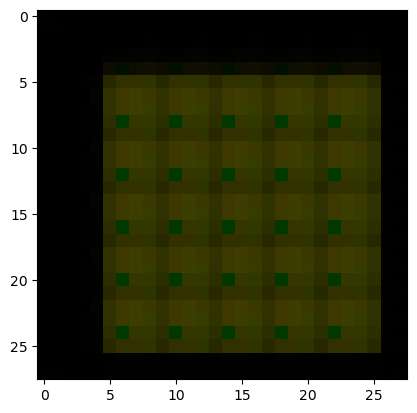

In [69]:
# Assume input_text is your input text
input_text = "23+1"

# Pad the input text with spaces if necessary
input_text = input_text.ljust(5)

# Encode the input text
input_text_encoded = encode_labels(np.array([input_text]))

# Generate the image
generated_image = text2image_model.predict(input_text_encoded)

# The generated_image will be a 4D array with shape (1, 28, 28, 3)
# To visualize the image, you can use matplotlib
import matplotlib.pyplot as plt

# Remove the batch dimension and scale the pixel values to [0, 255]
generated_image = np.squeeze(generated_image) * 255

# Display the image
plt.imshow(generated_image.astype('uint8'))
plt.show()


---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

(10000,) (10000, 5, 28, 28) (10000,) (10000, 5, 28, 28)
Query #1984

X_text: "19*84" = y_text: "1596 "


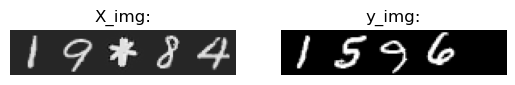

Query #9659

X_text: "96*59" = y_text: "5664 "


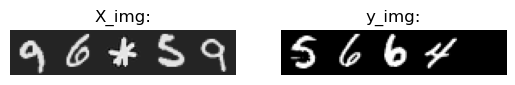

Query #4718

X_text: "47*18" = y_text: "846  "


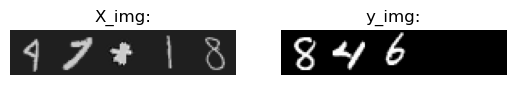

Query #9927

X_text: "99*27" = y_text: "2673 "


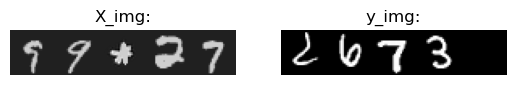

Query #7030

X_text: "70*30" = y_text: "2100 "


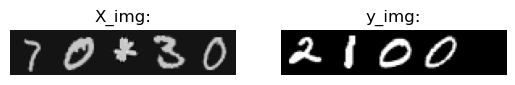

Query #9185

X_text: "91*85" = y_text: "7735 "


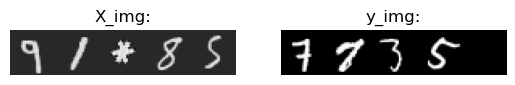

Query #8850

X_text: "88*50" = y_text: "4400 "


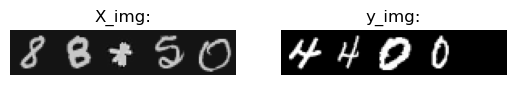

Query #1894

X_text: "18*94" = y_text: "1692 "


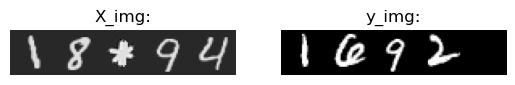

Query #5433

X_text: "54*33" = y_text: "1782 "


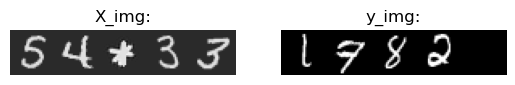

Query #91

X_text: "0*91 " = y_text: "0    "


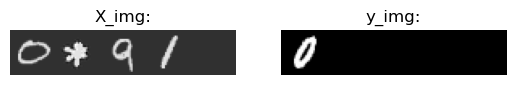

In [15]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

In [16]:
## Your code










